# importing libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from glob import glob
import cv2

# downloading camvid dataset

In [ ]:
!gdown "https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz"
!tar -xvzf /content/camvid.tgz
!gdown "http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip"
!gdown "http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt"
!unzip  /content/LabeledApproved_full.zip -d LabeledApproved_full

Downloading...
From: https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz
To: /content/camvid.tgz
100% 599M/599M [00:35<00:00, 16.7MB/s]
camvid/
camvid/codes.txt
camvid/images/
camvid/images/0016E5_00750.png
camvid/images/0006R0_f00990.png
camvid/images/0016E5_07410.png
camvid/images/Seq05VD_f00810.png
camvid/images/Seq05VD_f02280.png
camvid/images/0016E5_07987.png
camvid/images/0016E5_05040.png
camvid/images/0016E5_01560.png
camvid/images/0016E5_00780.png
camvid/images/0016E5_04380.png
camvid/images/0016E5_04830.png
camvid/images/0001TP_010110.png
camvid/images/0016E5_08430.png
camvid/images/0001TP_007410.png
camvid/images/0006R0_f03330.png
camvid/images/0016E5_06540.png
camvid/images/0016E5_01110.png
camvid/images/0001TP_008850.png
camvid/images/0001TP_007830.png
camvid/images/0006R0_f03570.png
camvid/images/Seq05VD_f05040.png
camvid/images/0001TP_009930.png
camvid/images/Seq05VD_f02400.png
camvid/images/Seq05VD_f03030.png
camvid/images/0016E5_02370.png
camvid/images/0016E5_08011.p

## color codecs of images

In [ ]:
labels = pd.read_csv('/content/label_colors.txt', sep=r"[ \t]+", names=['r', 'g', 'b', 'name'], header=None,index_col='name')
labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [ ]:
cls2rgb = {cl:list(labels.loc[cl, :]) for cl in labels.index}
cls2rgb

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'SUVPickupTruck': [64, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

# preprocessing

## loading data and apply resize and local normalization

In [ ]:
def load_input(folder_path):
  input = []
  image_filenames = sorted(glob(folder_path+'/*.png'))
  for i in image_filenames:
    rgb_img = cv2.imread(i)#.resize(225, 225)
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    equalized_img = equalized_img[:, :, [2, 1, 0]]
    equalized_img = cv2.resize(equalized_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    input.append(equalized_img)
    
  return np.array(input)


In [ ]:
def load_labeled_data(folder_path):
  input = []
  image_filenames = sorted(glob(folder_path+'/*.png'))
  for i in image_filenames:
    rgb_img = cv2.imread(i)#.resize(225, 225)
    rgb_img = rgb_img[:, :, [2, 1, 0]]
    rgb_img = cv2.resize(rgb_img, dsize=(256, 256))
    input.append(rgb_img)
  return np.array(input)


In [ ]:
input = load_input('/content/camvid/images')
masks = load_labeled_data('/content/LabeledApproved_full')

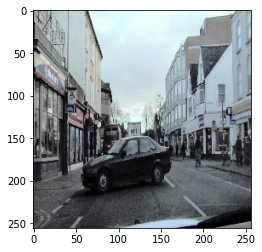

In [ ]:
plt.imshow(input[50])

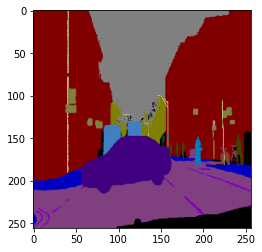

In [ ]:
plt.imshow(masks[50])

## creating labels

In [ ]:
idx2rgb=[np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())]
idx2rgb

[array([ 64, 128,  64]),
 array([192,   0, 128]),
 array([  0, 128, 192]),
 array([  0, 128,  64]),
 array([128,   0,   0]),
 array([ 64,   0, 128]),
 array([ 64,   0, 192]),
 array([192, 128,  64]),
 array([192, 192, 128]),
 array([ 64,  64, 128]),
 array([128,   0, 192]),
 array([192,   0,  64]),
 array([128, 128,  64]),
 array([192,   0, 192]),
 array([128,  64,  64]),
 array([ 64, 192, 128]),
 array([64, 64,  0]),
 array([128,  64, 128]),
 array([128, 128, 192]),
 array([  0,   0, 192]),
 array([192, 128, 128]),
 array([128, 128, 128]),
 array([ 64, 128, 192]),
 array([ 0,  0, 64]),
 array([ 0, 64, 64]),
 array([192,  64, 128]),
 array([128, 128,   0]),
 array([192, 128, 192]),
 array([64,  0, 64]),
 array([192, 192,   0]),
 array([0, 0, 0]),
 array([ 64, 192,   0])]

#### apply one hot encoding for each pixel

this function is from [this notebook](https://www.kaggle.com/drnykterstein/camvid-semantic-segmentation)

In [ ]:
def adjust_mask(mask):
    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        equality = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(equality)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.

    return np.float32(semantic_map)# convert to numbers

In [ ]:
masks = adjust_mask(masks)

In [ ]:
masks[50][0][0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
def conv_mask(masks):
  out = []
  for mask in masks:
    out.append(np.argmax(mask, axis=-1))
  return np.array(out)

In [ ]:
rgb_mask = conv_mask(masks)

In [ ]:
rgb_mask[50][0][0]

4

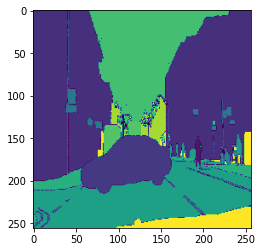

In [ ]:
plt.imshow(rgb_mask[50])

## split data to tain and test and validation

In [ ]:
train_data = []
for i in range(len(input)):
   train_data.append([input[i], rgb_mask[i]])
train,valid,test = torch.utils.data.random_split(train_data, [550,100,51])
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=4)
validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=4)
i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([4, 256, 256, 3])


# create model

In [ ]:
class SegNetBase(nn.Module):
    def __init__(self, input_channel):
        super(SegNetBase, self).__init__()

        batchNorm_momentum = 0.1

        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode4 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode3 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode2 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode1 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        
        self.dense_softmax_inner_prod = nn.Conv2d(64, 32, kernel_size=1)
      

    def forward(self, x):

        # Stage 1
        x1 = F.relu(self.conv1(x))
        x1p, id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x2 = F.relu(self.conv2(x1p))
        x2p, id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x3 = F.relu(self.conv3(x2p))
        x3p, id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x4 = F.relu(self.conv4(x3p))
        x4p, id4 = F.max_pool2d(x4,kernel_size=2, stride=2,return_indices=True)

        # Stage 4d
        x4d = F.max_unpool2d(x4p, id4, kernel_size=2, stride=2)
        x41 = self.conv_decode4(x4d)

        # Stage 3d
        x3d = F.max_unpool2d(x41, id3, kernel_size=2, stride=2)
        x31 = self.conv_decode3(x3d)

        # Stage 2d
        x2d = F.max_unpool2d(x31, id2, kernel_size=2, stride=2)
        x21 = self.conv_decode2(x2d)

        # Stage 1d
        x1d = F.max_unpool2d(x21, id1, kernel_size=2, stride=2)
        x12d = self.conv_decode1(x1d)
        x11d = self.dense_softmax_inner_prod(x12d)

        return x11d


In [ ]:
model = SegNetBase(3)

In [ ]:
import torch.optim as optim
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
model.to(device)

SegNetBase(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_decode4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn_decode4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_decode3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn_decode3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [ ]:
losss = []
validation = []
for epoch in range(60):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.permute((0,3,1,2)).float())
        outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
        outputs = torch.transpose(outputs,1,2).contiguous()
        outputs = outputs.view(-1,outputs.size(2))

        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    running_valid_loss = 0.0
    #validation
    model.eval()
    for j, valid_data in enumerate(validloader,0):
      valid_inputs, valid_labels = valid_data[0].to(device), valid_data[1].to(device)
       # forward + backward + optimize
      valid_outputs = model(valid_inputs.permute((0,3,1,2)).float())
      valid_outputs = valid_outputs.view(valid_outputs.size(0),valid_outputs.size(1), -1)
      valid_outputs = torch.transpose(valid_outputs,1,2).contiguous()
      valid_outputs = valid_outputs.view(-1,valid_outputs.size(2))
        
      valid_loss = criterion(valid_outputs, valid_labels.reshape(-1))

      running_valid_loss += valid_loss.item()

    #print statistics
    print(f'epoch: {epoch} -  loss :{running_loss / (i+1)} - validation loss : {running_valid_loss/(j+1)} batches: {i+1} ')
    losss.append(running_loss / (i+1))
    validation.append(running_valid_loss/(j+1))
    running_loss = 0.0
    running_valid_loss = 0.0

print('Finished Training')

epoch: 0 -  loss :3.0571497557819756 - validation loss : 2.291719980239868 batches: 138 
epoch: 1 -  loss :2.175188554369885 - validation loss : 2.0262300682067873 batches: 138 
epoch: 2 -  loss :1.7863358431968137 - validation loss : 1.6340101623535157 batches: 138 
epoch: 3 -  loss :1.501241942246755 - validation loss : 1.406005654335022 batches: 138 
epoch: 4 -  loss :1.39396654954855 - validation loss : 1.3455836915969848 batches: 138 
epoch: 5 -  loss :1.3668949880461763 - validation loss : 1.3712796831130982 batches: 138 
epoch: 6 -  loss :1.3162254064843275 - validation loss : 1.3053841161727906 batches: 138 
epoch: 7 -  loss :1.251385049543519 - validation loss : 1.2557820224761962 batches: 138 
epoch: 8 -  loss :1.2063931304475535 - validation loss : 1.190006709098816 batches: 138 
epoch: 9 -  loss :1.158720221640407 - validation loss : 1.1614600467681884 batches: 138 
epoch: 10 -  loss :1.131297821583955 - validation loss : 1.1189228463172913 batches: 138 
epoch: 11 -  loss :

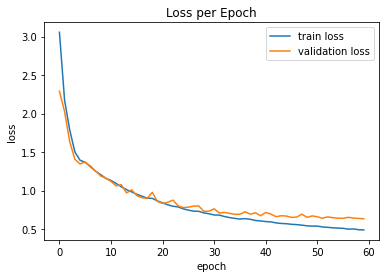

In [ ]:
plt.title("Loss per Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(losss, label ="train loss")
plt.plot(validation, label = "validation loss")
plt.legend()
plt.show()

# test the model

In [ ]:
testloader = torch.utils.data.DataLoader(test)

In [ ]:
def plot_test(model, testloader):

  # Map the idx back to rgb
  def map_class_to_rgb(p):
    return idx2rgb[p[0]]

  fig=plt.figure(figsize=(12, 35))
  testloader = torch.utils.data.DataLoader(test)
  out=[]
  test_img = []
  test_label = []
  j=0
  #select 10 images
  for i in testloader:
    if j ==10:
      break
    test_,test_lbl = i[0],i[1]
    torch.cuda.empty_cache()
    out1 = model(test_.permute((0,3,1,2)).float().to(device))
    torch.cuda.empty_cache()
    out.append(out1)
    test_img.append(test_[0])
    test_label.append(test_lbl[0])
    j+=1
  i=0
  j=0
  for i in range(9):
    j+=1
    #print(out[0].size())
    rgbb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(out[i].permute(0,2,3,1).cpu().detach().numpy(), axis=-1), -1))
    fig.add_subplot(9, 3, j)
    plt.title('Network Output')
    plt.imshow(rgbb_mask[0])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title('real image')
    plt.imshow(test_img[i])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title("real segmentation")
    plt.imshow(test_label[i])

  plt.show()



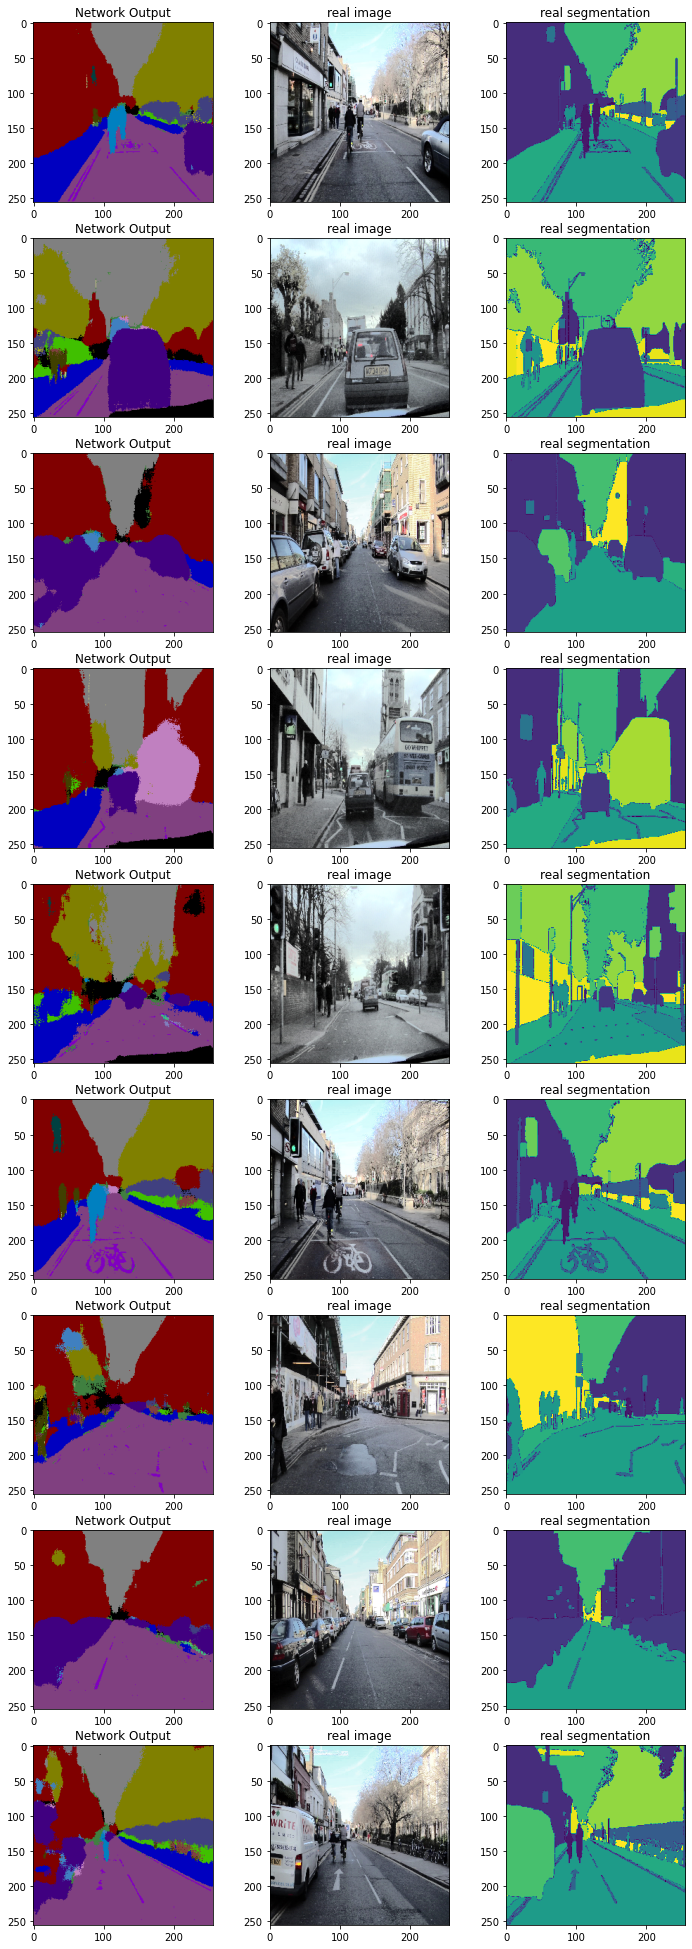

In [ ]:
plot_test(model, testloader)

# save model

In [ ]:
torch.save(model,'/content/sample_data/segnetBase.pth')

# Adding Batch normalization

In [ ]:
class SegNetBaseBatchNorm(nn.Module):
    def __init__(self, input_channel):
        super(SegNetBaseBatchNorm, self).__init__()

        batchNorm_momentum = 0.1

        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode4 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode3 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode2 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode1 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        
        self.dense_softmax_inner_prod = nn.Conv2d(64, 32, kernel_size=1)
      

    def forward(self, x):

        # Stage 1
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1p, id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x2 = F.relu(self.bn2(self.conv2(x1p)))
        x2p, id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x3 = F.relu(self.bn3(self.conv3(x2p)))
        x3p, id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x4 = F.relu(self.bn4(self.conv4(x3p)))
        x4p, id4 = F.max_pool2d(x4,kernel_size=2, stride=2,return_indices=True)

        # Stage 4d
        x4d = F.max_unpool2d(x4p, id4, kernel_size=2, stride=2)
        x41 = self.bn_decode4(self.conv_decode4(x4d))

        # Stage 3d
        x3d = F.max_unpool2d(x41, id3, kernel_size=2, stride=2)
        x31 = self.bn_decode3(self.conv_decode3(x3d))

        # Stage 2d
        x2d = F.max_unpool2d(x31, id2, kernel_size=2, stride=2)
        x21 = self.bn_decode2(self.conv_decode2(x2d))

        # Stage 1d
        x1d = F.max_unpool2d(x21, id1, kernel_size=2, stride=2)
        x12d = self.bn_decode1(self.conv_decode1(x1d))
        x11d = self.dense_softmax_inner_prod(x12d)

        return x11d


In [ ]:
model_BN = SegNetBaseBatchNorm(3)

In [ ]:
import torch.optim as optim
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_BN.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
model_BN.to(device)

SegNetBaseBatchNorm(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_decode4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn_decode4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_decode3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn_decode3): BatchNorm2d(64, eps=1e-05, momentum=

# train model with batch normalization

In [ ]:
losss_batch = []
validation_batch = []
for epoch in range(60): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_BN(inputs.permute((0,3,1,2)).float())
        outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
        outputs = torch.transpose(outputs,1,2).contiguous()
        outputs = outputs.view(-1,outputs.size(2))
        #calculate loss
        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_valid_loss = 0.0

    # validation
    model_BN.eval()
    for j, valid_data in enumerate(validloader,0):
      valid_inputs, valid_labels = valid_data[0].to(device), valid_data[1].to(device)
       # forward + backward + optimize
      valid_outputs = model_BN(valid_inputs.permute((0,3,1,2)).float())
      valid_outputs = valid_outputs.view(valid_outputs.size(0),valid_outputs.size(1), -1)
      valid_outputs = torch.transpose(valid_outputs,1,2).contiguous()
      valid_outputs = valid_outputs.view(-1,valid_outputs.size(2))
        
      valid_loss = criterion(valid_outputs, valid_labels.reshape(-1))

      running_valid_loss += valid_loss.item()

    print(f'epoch: {epoch} -  loss :{running_loss / (i+1)} - validation loss : {running_valid_loss/(j+1)} batches: {i+1} ')
    losss_batch.append(running_loss / (i+1))
    validation_batch.append(running_valid_loss/(j+1))
    running_loss = 0.0
    running_valid_loss = 0.0

print('Finished Training')

epoch: 0 -  loss :2.106205163658529 - validation loss : 1.5047357177734375 batches: 138 
epoch: 1 -  loss :2.065178606821143 - validation loss : 1.4625502634048462 batches: 138 
epoch: 2 -  loss :1.410336433113485 - validation loss : 1.395097861289978 batches: 138 
epoch: 3 -  loss :1.3123331933781721 - validation loss : 1.2518556690216065 batches: 138 
epoch: 4 -  loss :1.20517133888991 - validation loss : 1.1769833636283875 batches: 138 
epoch: 5 -  loss :1.1855248480603315 - validation loss : 1.2445252704620362 batches: 138 
epoch: 6 -  loss :1.129206198281136 - validation loss : 1.1058018922805786 batches: 138 
epoch: 7 -  loss :1.0660893346952356 - validation loss : 1.0803368067741395 batches: 138 
epoch: 8 -  loss :1.0309872882089752 - validation loss : 0.9997821021080017 batches: 138 
epoch: 9 -  loss :0.9998558042705923 - validation loss : 1.046391818523407 batches: 138 
epoch: 10 -  loss :0.9896892551062764 - validation loss : 0.9666997909545898 batches: 138 
epoch: 11 -  loss

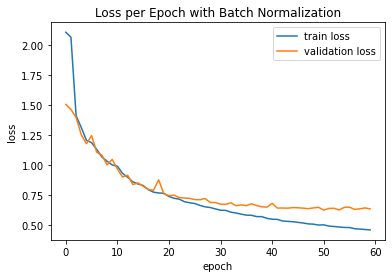

In [ ]:
plt.title("Loss per Epoch with Batch Normalization")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(losss_batch, label ="train loss")
plt.plot(validation_batch, label = "validation loss")
plt.legend()
plt.show()

## test results for model with batch normalization

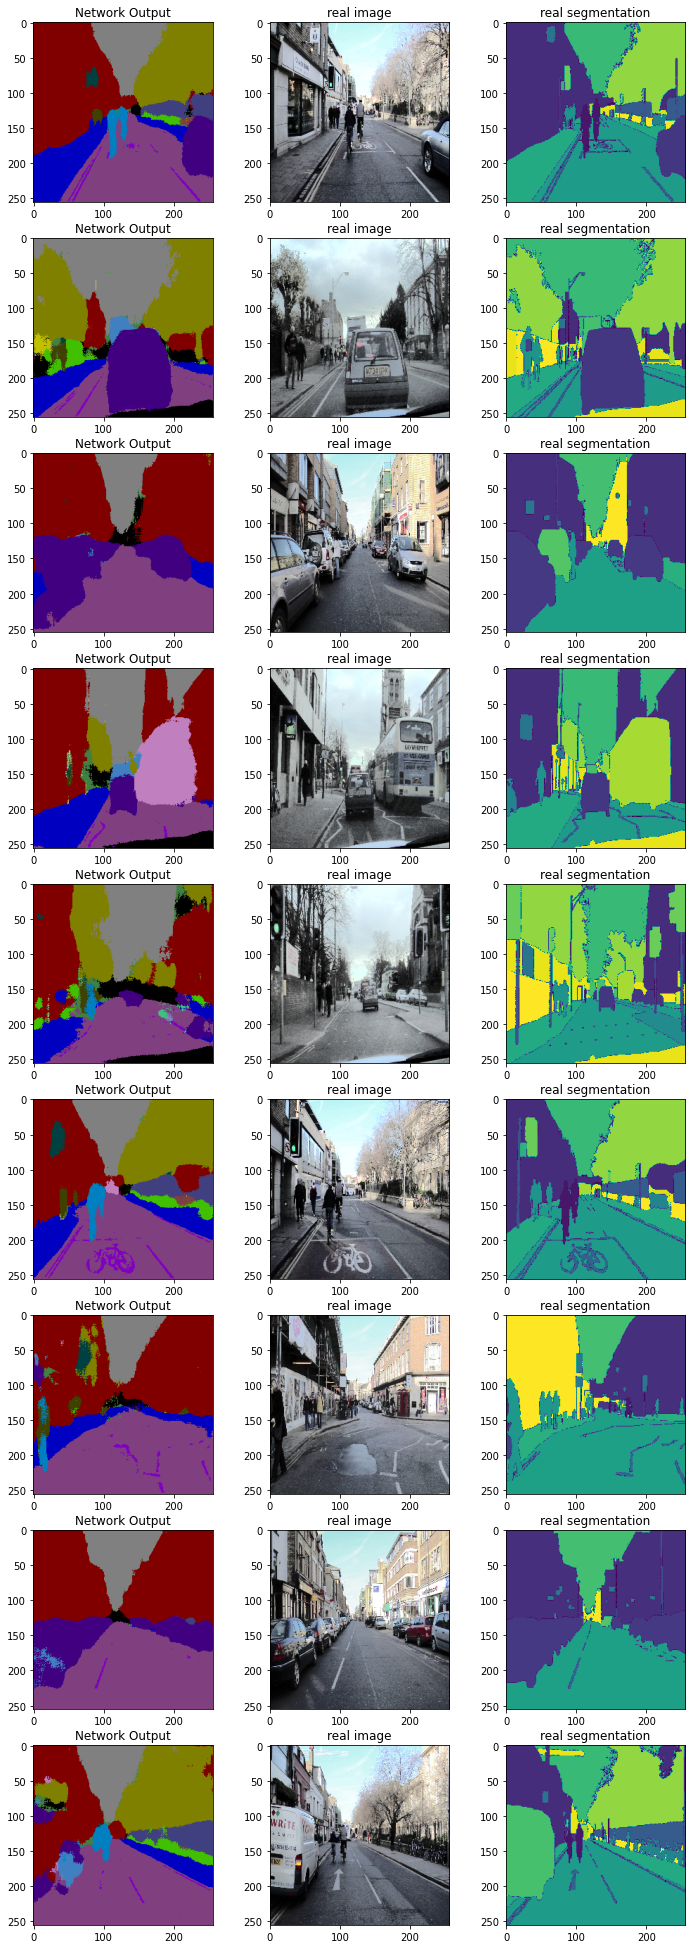

In [ ]:
plot_test(model_BN, testloader)